# Generative Adversarial Network (GAN) - MNIST Digit Generation
This notebook implements a GAN using custom training loop.

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
import os

## Load and Preprocess Data

In [2]:
# Load MNIST
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Scale to [-1, 1] for tanh activation
x_train = (x_train.astype('float32') / 255.0) * 2 - 1
x_test = (x_test.astype('float32') / 255.0) * 2 - 1

# Flatten
N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

print(f"Training data shape: {x_train.shape}")
print(f"Data range: [{x_train.min():.2f}, {x_train.max():.2f}]")

Training data shape: (60000, 784)
Data range: [-1.00, 1.00]


## Hyperparameters

In [3]:
latent_dim = 100
batch_size = 128
epochs = 30000
sample_period = 200

## Build Models

In [4]:
def build_generator(latent_dim):
    model = tf.keras.Sequential([
        Dense(256, input_shape=(latent_dim,)),
        LeakyReLU(negative_slope=0.2),
        BatchNormalization(momentum=0.8),
        
        Dense(512),
        LeakyReLU(negative_slope=0.2),
        BatchNormalization(momentum=0.8),
        
        Dense(1024),
        LeakyReLU(negative_slope=0.2),
        BatchNormalization(momentum=0.8),
        
        Dense(D, activation='tanh')
    ], name='Generator')
    return model

def build_discriminator(img_size):
    model = tf.keras.Sequential([
        Dense(512, input_shape=(img_size,)),
        LeakyReLU(negative_slope=0.2),
        
        Dense(256),
        LeakyReLU(negative_slope=0.2),
        
        Dense(1, activation='sigmoid')
    ], name='Discriminator')
    return model

In [5]:
# Create models
generator = build_generator(latent_dim)
discriminator = build_discriminator(D)

print("Generator:")
generator.summary()
print("\nDiscriminator:")
discriminator.summary()

C:\Users\nihal\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Generator:


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │          25,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 784)                 │         803,600 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,493,520 (5.70 MB)

 Trainable params: 1,489,936 (5.68 MB)

 Non-trainable params: 3,584 (14.00 KB)


Discriminator:


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 512)                 │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 533,505 (2.04 MB)

 Trainable params: 533,505 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

## Setup Optimizers and Loss

In [6]:
# Separate optimizers for generator and discriminator
g_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
d_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

# Loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy()

## Custom Training Functions

In [7]:
@tf.function
def train_discriminator(real_images, batch_size):
    """Train discriminator on real and fake images"""
    # Generate fake images
    noise = tf.random.normal([batch_size, latent_dim])
    fake_images = generator(noise, training=False)
    
    with tf.GradientTape() as tape:
        # Get discriminator predictions
        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(fake_images, training=True)
        
        # Calculate losses
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
    
    # Calculate gradients and update weights
    gradients = tape.gradient(total_loss, discriminator.trainable_variables)
    d_optimizer.apply_gradients(zip(gradients, discriminator.trainable_variables))
    
    # Calculate accuracy
    real_acc = tf.reduce_mean(tf.cast(real_output > 0.5, tf.float32))
    fake_acc = tf.reduce_mean(tf.cast(fake_output < 0.5, tf.float32))
    total_acc = (real_acc + fake_acc) / 2
    
    return total_loss, total_acc

@tf.function
def train_generator(batch_size):
    """Train generator to fool discriminator"""
    noise = tf.random.normal([batch_size, latent_dim])
    
    with tf.GradientTape() as tape:
        fake_images = generator(noise, training=True)
        fake_output = discriminator(fake_images, training=False)
        
        # Generator wants discriminator to think these are real (label = 1)
        loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    
    gradients = tape.gradient(loss, generator.trainable_variables)
    g_optimizer.apply_gradients(zip(gradients, generator.trainable_variables))
    
    return loss

## Utility Functions

In [8]:
def sample_images(epoch):
    """Generate and save sample images"""
    rows, cols = 5, 5
    noise = np.random.randn(rows * cols, latent_dim)
    imgs = generator.predict(noise, verbose=0)
    
    # Rescale to [0, 1]
    imgs = 0.5 * imgs + 0.5
    
    fig, axs = plt.subplots(rows, cols, figsize=(10, 10))
    idx = 0
    for i in range(rows):
        for j in range(cols):
            axs[i, j].imshow(imgs[idx].reshape(H, W), cmap='gray')
            axs[i, j].axis('off')
            idx += 1
    
    fig.savefig(f'gan_images/{epoch}.png')
    plt.close()

# Create output directory
if not os.path.exists('gan_images'):
    os.makedirs('gan_images')
    print("Created 'gan_images' directory")

## Training Loop

In [9]:
# Training history
d_losses = []
g_losses = []

print("Starting training...\n")

for epoch in range(epochs):
    # Get random batch of real images
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_imgs = x_train[idx]
    
    # Train discriminator
    d_loss, d_acc = train_discriminator(real_imgs, batch_size)
    
    # Train generator
    g_loss = train_generator(batch_size)
    
    # Store losses
    d_losses.append(float(d_loss))
    g_losses.append(float(g_loss))
    
    # Print progress
    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{epochs} | D Loss: {d_loss:.4f} | D Acc: {d_acc:.4f} | G Loss: {g_loss:.4f}")
    
    # Save sample images
    if epoch % sample_period == 0:
        sample_images(epoch)

print("\nTraining completed!")

Starting training...

Epoch 0/30000 | D Loss: 1.0522 | D Acc: 0.8789 | G Loss: 0.6589
Epoch 100/30000 | D Loss: 0.0397 | D Acc: 1.0000 | G Loss: 4.1949
Epoch 200/30000 | D Loss: 0.2887 | D Acc: 0.9688 | G Loss: 2.6389
Epoch 300/30000 | D Loss: 0.8190 | D Acc: 0.7500 | G Loss: 2.3068
Epoch 400/30000 | D Loss: 1.1877 | D Acc: 0.4727 | G Loss: 0.8396
Epoch 500/30000 | D Loss: 1.1573 | D Acc: 0.8555 | G Loss: 0.6846
Epoch 600/30000 | D Loss: 1.2170 | D Acc: 0.7109 | G Loss: 0.5732
Epoch 700/30000 | D Loss: 1.2217 | D Acc: 0.7773 | G Loss: 0.6330
Epoch 800/30000 | D Loss: 1.2378 | D Acc: 0.4883 | G Loss: 0.9265
Epoch 900/30000 | D Loss: 1.1765 | D Acc: 0.7969 | G Loss: 0.7610
Epoch 1000/30000 | D Loss: 1.2165 | D Acc: 0.6836 | G Loss: 0.9183
Epoch 1100/30000 | D Loss: 1.1841 | D Acc: 0.6641 | G Loss: 0.5770
Epoch 1200/30000 | D Loss: 1.1606 | D Acc: 0.6992 | G Loss: 1.0321
Epoch 1300/30000 | D Loss: 1.2732 | D Acc: 0.6367 | G Loss: 0.7369
Epoch 1400/30000 | D Loss: 1.3407 | D Acc: 0.5742 | 

## Visualize Training

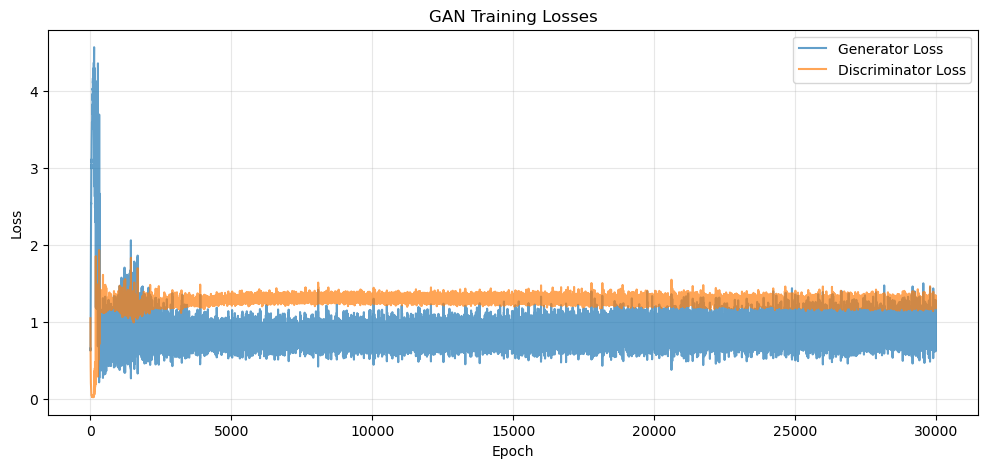

In [10]:
plt.figure(figsize=(12, 5))
plt.plot(g_losses, label='Generator Loss', alpha=0.7)
plt.plot(d_losses, label='Discriminator Loss', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Losses')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## View Generated Images

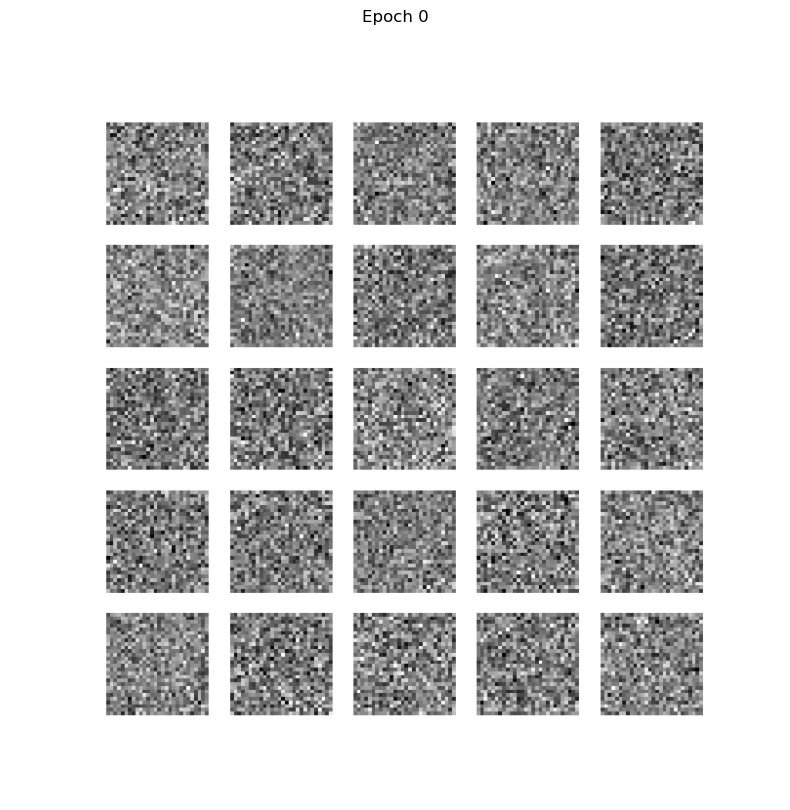

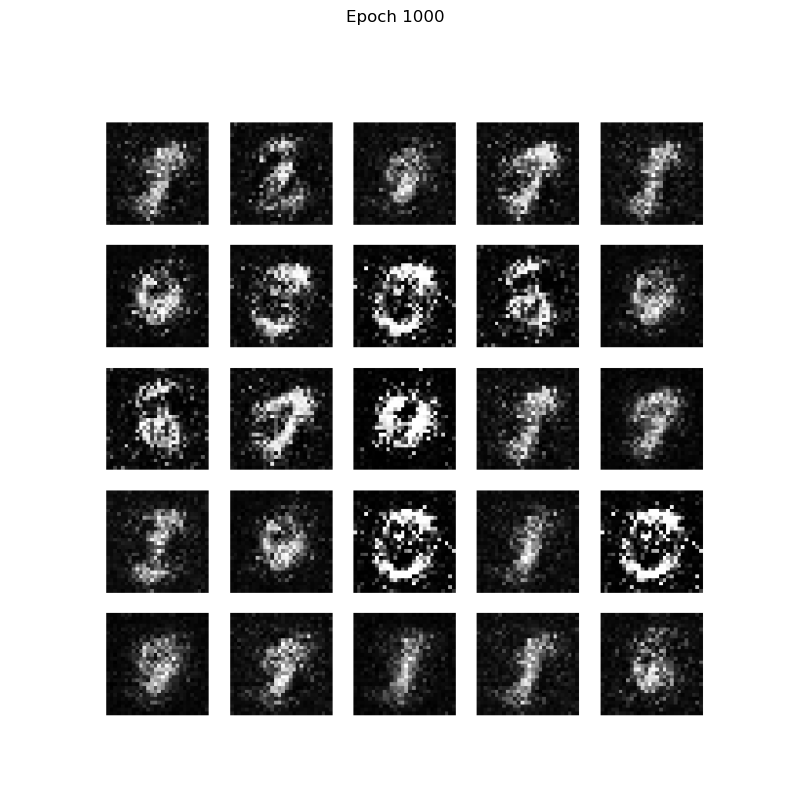

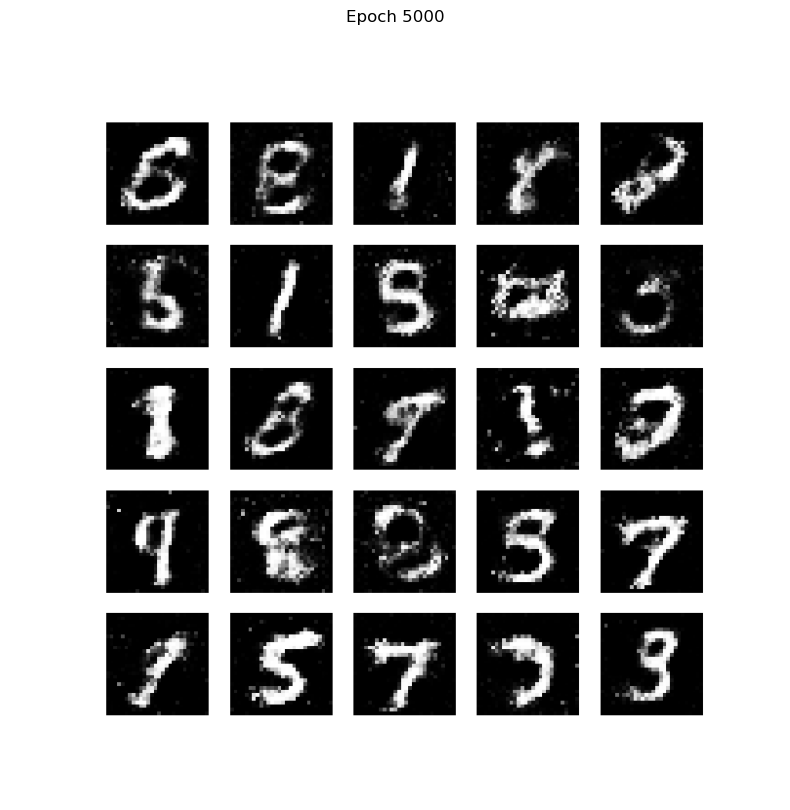

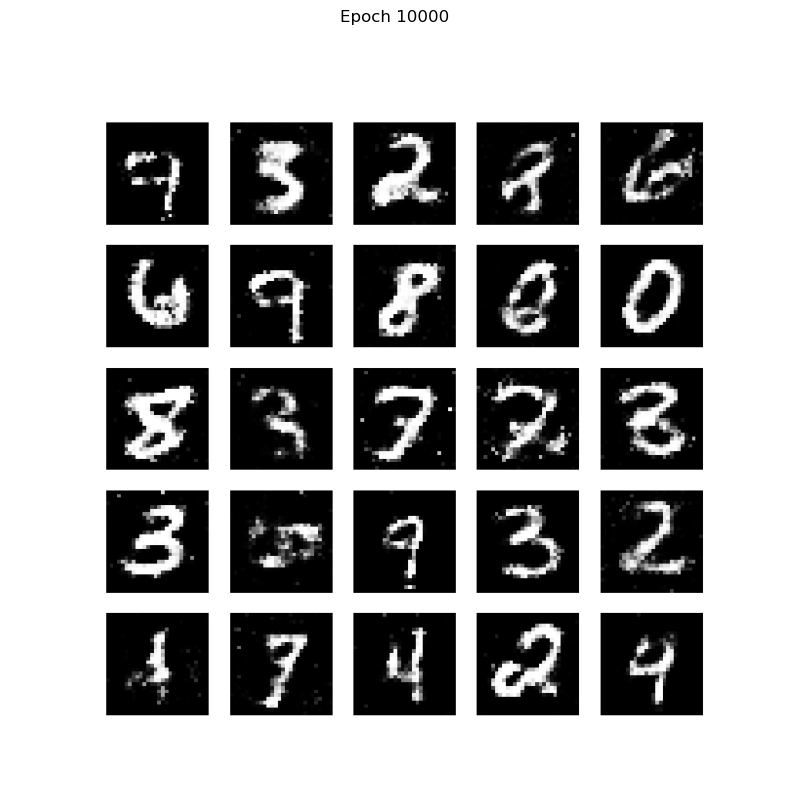

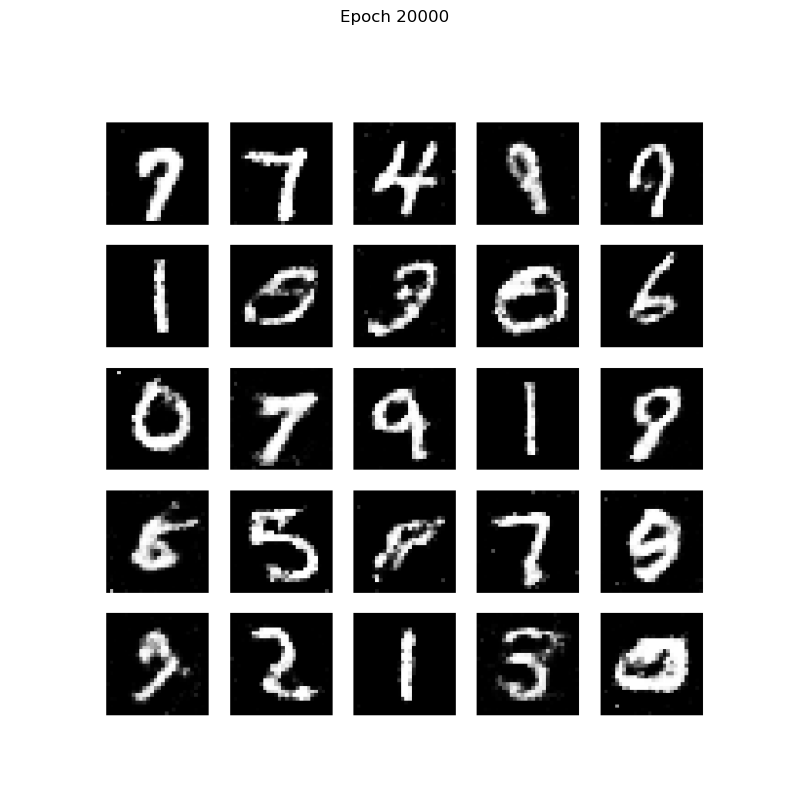

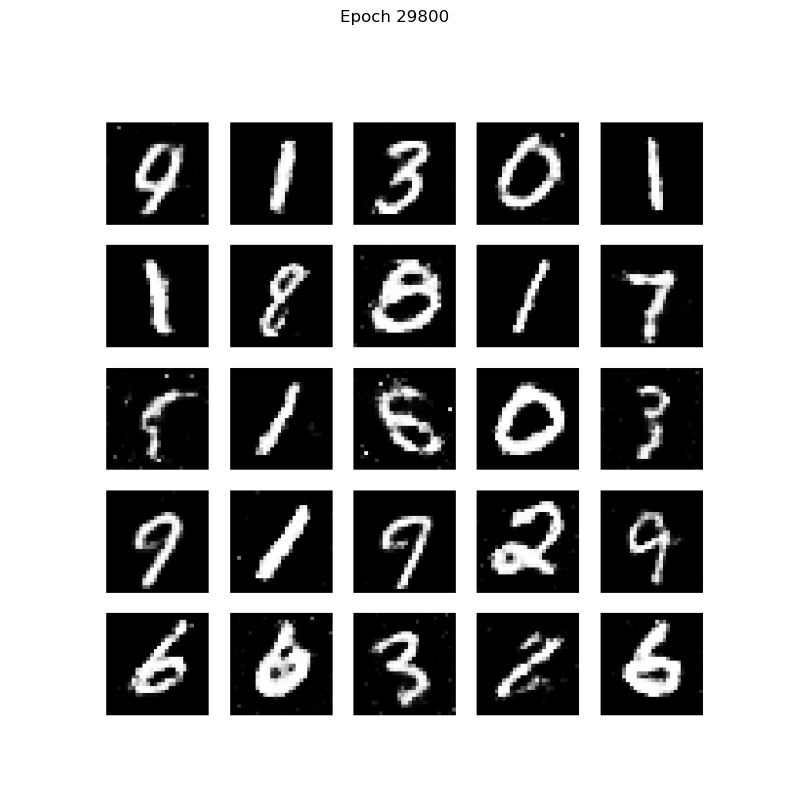

In [11]:
from matplotlib.pyplot import imread

def display_generated_image(epoch_num):
    img_path = f'gan_images/{epoch_num}.png'
    if os.path.exists(img_path):
        img = imread(img_path)
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Epoch {epoch_num}')
        plt.show()
    else:
        print(f"Image not found: {img_path}")

# Display progression
for epoch in [0, 1000, 5000, 10000, 20000, 29800]:
    if epoch < epochs:
        display_generated_image(epoch)

## Generate New Images

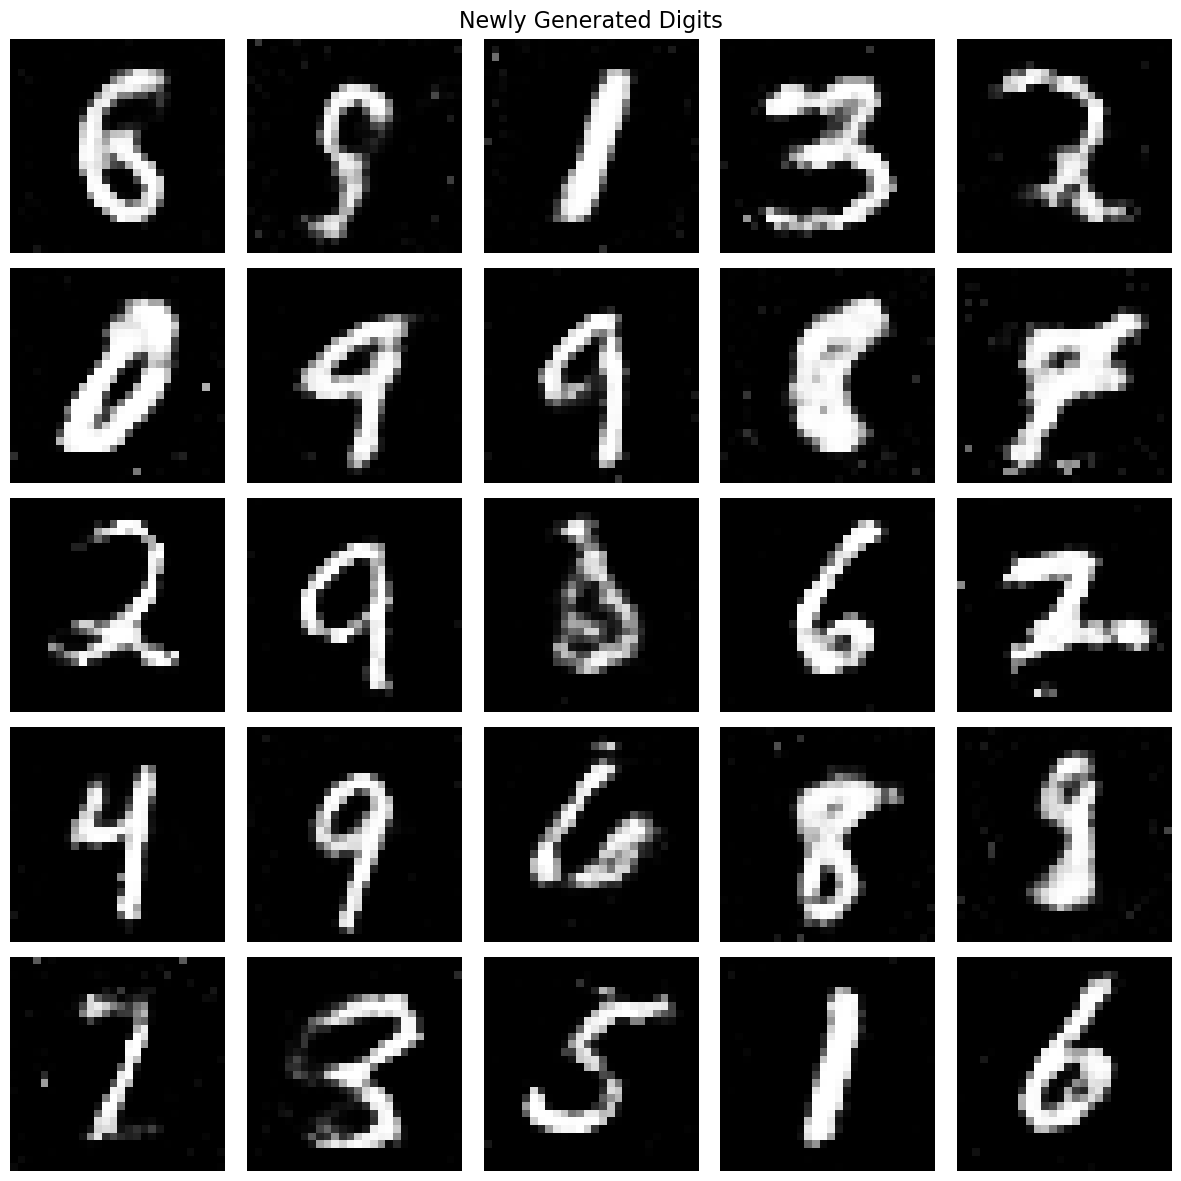

In [12]:
# Generate fresh samples
num_samples = 25
noise = np.random.randn(num_samples, latent_dim)
generated_imgs = generator.predict(noise, verbose=0)
generated_imgs = 0.5 * generated_imgs + 0.5

fig, axs = plt.subplots(5, 5, figsize=(12, 12))
idx = 0
for i in range(5):
    for j in range(5):
        axs[i, j].imshow(generated_imgs[idx].reshape(H, W), cmap='gray')
        axs[i, j].axis('off')
        idx += 1
plt.suptitle('Newly Generated Digits', fontsize=16)
plt.tight_layout()
plt.show()

## Save Models

In [13]:
generator.save('generator_model.keras')
discriminator.save('discriminator_model.keras')
print("Models saved!")

Models saved!
